In [1]:
%matplotlib inline

from __future__ import absolute_import, division, print_function

from itertools import product
from os.path import expanduser, expandvars, join
import os
import sys
from time import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
from pisa import ureg
from pisa.core.binning import OneDimBinning
from pisa.core.map import Map

<< PISA is running in double precision (FP64) mode; numba is running on GPU >>


In [3]:
retro_path = expanduser(expandvars('~/src/retro'))
if retro_path not in sys.path:
    sys.path.append(retro_path)

In [155]:
from retro import *
from retro.table_readers import *

In [5]:
def plot_sphere(ax):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    # Plot the surface
    sph = ax.plot_surface(x, y, z, alpha=0.2)
    return sph

In [6]:
def plot_points_on_sph(x, y, z, ax_x, ax_y, ax_z, title=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8), dpi=72)
        ax = fig.add_subplot(111, projection='3d')
    fig = ax.figure
    
    axlw = 3
    xs, ys, zs = coords2xsyszs(((0, 0, 0), (0, 0, 1)))
    ax.plot(xs, ys, zs, '-', color='k', lw=axlw, alpha=1)
    xs, ys, zs = coords2xsyszs(((0, 0, 0), (0, 1, 0)))
    ax.plot(xs, ys, zs, '-', color='k', lw=axlw, alpha=1)
    xs, ys, zs = coords2xsyszs(((0, 0, 0), (1, 0, 0)))
    ax.plot(xs, ys, zs, '-', color='k', lw=axlw, alpha=1)
    
    xs, ys, zs = coords2xsyszs(((0, 0, 0), (ax_x, ax_y, ax_z)))
    ax.plot(xs, ys, zs, '-', color='C0', lw=1, alpha=1)
    
    alpha = 0.25
    xs, ys, zs = coords2xsyszs(((-1, 0, 0), (-1, ax_y, ax_z)))
    #print(xs, ys, zs)
    ax.plot(xs, ys, zs, '-', color='k', lw=2, alpha=alpha)
    
    xs, ys, zs = coords2xsyszs(((0, -1, 0), (ax_x, -1, ax_z)))
    ax.plot(xs, ys, zs, '-', color='k', lw=2, alpha=alpha)
    
    xs, ys, zs = coords2xsyszs(((0, 0, -1), (ax_x, ax_y, -1)))
    ax.plot(xs, ys, zs, '-', color='k', lw=2, alpha=alpha)
    
    sph = plot_sphere(ax)
    
    pts = ax.scatter(x, y, z, marker='o', color='C2', s=1)
    
    ax.axis('image')
    ax.view_init(30, 30)
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    #ax.set_xlabel('$x$')
    #ax.set_ylabel('$y$')
    #ax.set_zlabel('$z$')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([-1, 0, 1])
    if title:
        ax.set_title(title)
    #ax.grid(False)
    #ax.set_axis_off()
    fig.tight_layout()
    
    return fig, ax, pts, sph

In [7]:
def coords2xsyszs(coords):
    if len(coords[0]) == 2:
        xs, ys, zs = [c[0] for c in coords], [c[1] for c in coords], [0 for c in coords]
    elif len(coords[0]) == 3:
        xs, ys, zs = [c[0] for c in coords], [c[1] for c in coords], [c[2] for c in coords]
    else:
        raise ValueError()
    return xs, ys, zs

In [8]:
outdir = 'cone_in_spherical_coords'
mkdir(outdir)

In [9]:
ftype = np.float64
n_samp = int(1e3)
bin_phi = 0
R = 1
n = 1.5 # phase vel. in ice
beta = 1 # approx. vel of muon relative to c
cherenkov_angle = np.arccos(1/(n * beta))
print('Cherenkov angle: {:.3f} deg'.format(np.rad2deg(cherenkov_angle)))

Cherenkov angle: 48.190 deg


Let's start by defining the cone with axis colinear with the $z$-axis and take some number of samples from the circle where that cone intersects the unit sphere.

In [10]:
r = np.full(n_samp, R, dtype=ftype)
phi = np.linspace(0, 2*np.pi * (1 - 1/n_samp), n_samp, dtype=ftype)
theta = np.full(n_samp, cherenkov_angle, dtype=ftype)
#print('r:', r[0])
#print('theta:', np.rad2deg(theta[0]))
#print('phi:', np.rad2deg(phi))

In [11]:
x, y, z = np.empty(n_samp, dtype=ftype), np.empty(n_samp, dtype=ftype), np.empty(n_samp, dtype=ftype)
sph2cart(r, theta, phi, x, y, z)
points = np.stack((x, y, z))

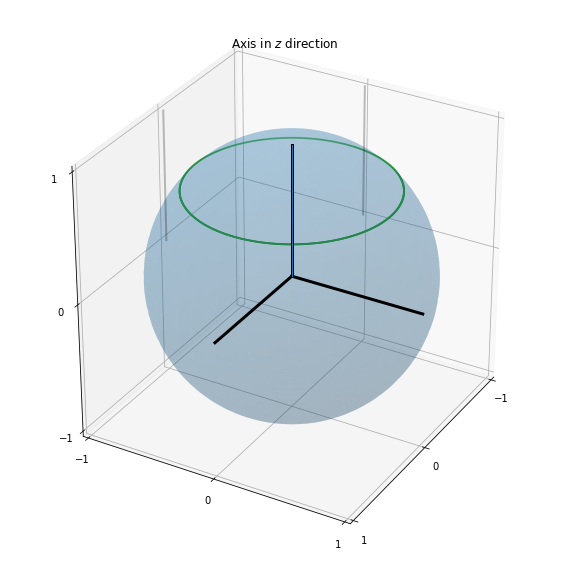

In [12]:
fig, ax, pts, sph = plot_points_on_sph(x, y, z, 0, 0, 1, title='Axis in $z$ direction')

Now rotate the cone to have its axis aligned with an arbitrary (unit) vector defined by $\theta$, $\phi$ angles.

KeyboardInterrupt: 

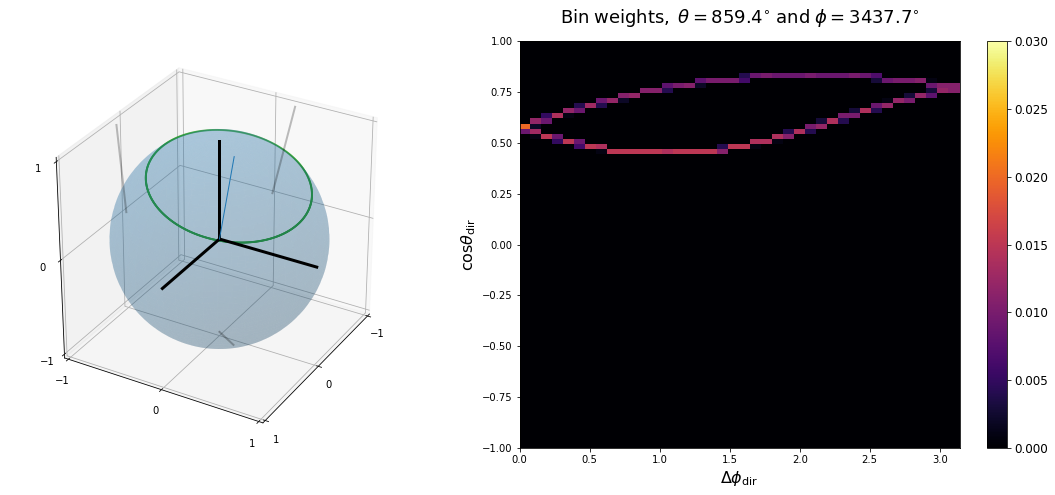

In [35]:
ax_r = np.array([1], dtype=ftype)
ax_x, ax_y, ax_z = np.empty(1, dtype=ftype), np.empty(1, dtype=ftype), np.empty(1, dtype=ftype)

thetas = np.arange(0, 180+1, 15)
phis = np.arange(0, 360, 15)

theta0_computed = False
theta180_computed = False

for theta, phi in product(thetas, phis):
    if theta == 0 and theta0_computed:
        continue
    elif theta == 180 and theta180_computed:
        continue
    plt.close(1)
    fig = plt.figure(num=1, figsize=(16, 7), dpi=72)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    ax_theta = np.array([np.deg2rad(theta)], dtype=ftype)
    ax_phi = np.array([np.deg2rad(phi)], dtype=ftype)
    sph2cart(ax_r, ax_theta, ax_phi, ax_x, ax_y, ax_z)

    orig_ax = [0, 0, 1]
    new_ax = [float(ax_x), float(ax_y), float(ax_z)]

    ct = np.cos(float(ax_theta))
    st = np.sin(float(ax_theta))
    Ry = np.array(
        [[ct, 0, st],
         [0, 1, 0],
         [-st, 0, ct]]
    )
    cp = np.cos(float(ax_phi))
    sp = np.sin(float(ax_phi))
    Rz = np.array(
        [[cp, -sp, 0],
         [sp, cp, 0],
         [0, 0, 1]]
    )
    new_points = np.matmul(Rz, np.matmul(Ry, points))
    fig, ax, pts, sph = plot_points_on_sph(
        new_points[0,:], new_points[1,:], new_points[2,:],
        ax_x, ax_y, ax_z, ax=ax1
    )

    # Convert to spherical coords

    new_r, new_theta, new_phi = np.empty(n_samp, dtype=ftype), np.empty(n_samp, dtype=ftype), np.empty(n_samp, dtype=ftype)
    cart2sph(new_points[0,:], new_points[1,:], new_points[2,:], new_r, new_theta, new_phi)
    new_costheta = np.cos(new_theta)
    assert np.allclose(new_r, 1)
    dpdir_b = OneDimBinning('deltaphidir', tex=r'\Delta\phi_{\rm dir}',
                            domain=[0, np.pi], is_lin=True, num_bins=40)
    ctdir_b = OneDimBinning('costhetadir', tex=r'\cos\theta_{\rm dir}',
                            domain=[-1, 1], is_lin=True, num_bins=80)
    binning = dpdir_b * ctdir_b
    hist, edges = np.histogramdd(
        (np.abs(new_phi - bin_phi), new_costheta),
        bins=binning.bin_edges,
        normed=False
    )
    hist = hist / hist.sum()
    hist = Map(
        name='hist',
        tex=(r'{\rm Bin \; weights}, \; \theta=%.1f^{\circ} \; {\rm and} \; \phi=%.1f^{\circ}'
             % (np.rad2deg(theta), np.rad2deg(phi))),
        hist=hist,
        binning=binning
    )
    #print('number of nonzero bins:', np.sum(hist.hist > 0))
    hist.plot(vmax=0.03, ax=ax2, titlesize=18, xlabelsize=16, ylabelsize=16)
    fig.tight_layout()
    fig.savefig(
        join(outdir, 'theta{}_phi{}.png'.format(theta, phi)),
        dpi=120
    )
    if theta == 0:
        theta0_computed = True
    elif theta == 180:
        theta180_computed = True
pass

In [158]:
import sympy
from sympy import (
    acos, asin, sin, cos, tan, atan, atan2, sqrt, symbols, Matrix,
    simplify, init_printing, trigsimp
)
init_printing()

In [159]:
theta, phi = symbols('theta, phi')
p_x, p_y, p_z = symbols('p_x, p_y, p_z')
p_r, p_theta, p_phi = symbols('p_r p_theta p_phi')
p_r = 1

In [160]:
p_z = cos(p_theta)
p_rho = sin(p_theta)
p_x = p_rho * cos(p_phi)
p_y = p_rho * sin(p_phi)

Create the rotation matrix

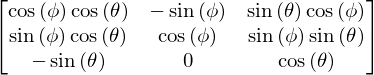

In [161]:
# Rotation about y axis
Ry = sympy.Matrix(
    [[ cos(theta),  0, sin(theta)],
     [          0,  1,          0],
     [-sin(theta),  0, cos(theta)]]
)

# Rotation about z axis
Rz = sympy.Matrix(
    [[cos(phi), -sin(phi),  0],
     [sin(phi),  cos(phi),  0],
     [       0,         0,  1]]
)

# Total rotation is first rotate about y axis and then rotate about z axis
R = simplify(trigsimp(Rz * Ry))
R

Apply the rotation matrix to the pdir vector with components $p_x$, $p_y$, and $p_z$.
The rotated vector is $p'$ (p_prime).

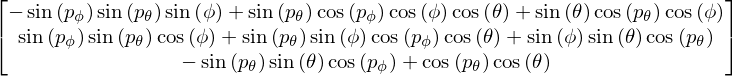

In [132]:
p_prime = simplify(trigsimp(R * Matrix([[p_x], [p_y], [p_z]])))
p_prime

In [133]:
costheta_prime = p_prime[2]
costheta_prime

In [134]:
phi_prime = simplify(trigsimp(atan2(p_prime[1], p_prime[0])))
phi_prime

Translate the above symbolic bits into a numba-fied function.

In [141]:
@numba_jit
def rotate_circle_on_sphere(p_theta, p_phi, rot_theta, rot_phi):
    """
    Parameters
    ----------
    p_theta : scalar float
        All points in the circle share the same theta coordinate.
        
    p_phi : 1D array
        Azimuth of each point on the circle
        
    rot_theta : scalar float
        Rotate the circle to have axis of symmetry defined by (rot_theta, rot_phi)
        
    rot_phi : scalar float
        Rotate the circle to have axis of symmetry defined by (rot_theta, rot_phi)

    Returns
    -------
    q_costheta : 1d array, same size as `p_phi`
        The points on the rotated circle have these costheta coordinates.
        
    q_phi : 1d array, same size as `p_phi`
        The points on the rotated circle have these phi coordinates.

    """
    num_p = len(p_phi)
    q_costheta = np.empty(num_p)
    q_phi = np.empty(num_p)

    sin_rot_theta = np.sin(rot_theta)
    cos_rot_theta = np.cos(rot_theta)
    
    sin_rot_phi = np.sin(rot_phi)
    cos_rot_phi = np.cos(rot_phi)

    sin_p_theta = np.sin(p_theta)
    cos_p_theta = np.cos(p_theta)

    for idx in range(num_p):
        p_phi_ = p_phi[idx]
        sin_p_phi = np.sin(p_phi_)
        cos_p_phi = np.cos(p_phi_)
        q_costheta[idx] = -sin_p_theta * sin_rot_theta * cos_p_phi + cos_p_theta * cos_rot_theta
        q_phi[idx] = np.arctan2(
            (sin_p_phi * sin_p_theta * cos_rot_phi) + (sin_p_theta * sin_rot_phi * cos_p_phi * cos_rot_theta) + (sin_rot_phi * sin_rot_theta * cos_p_theta),
            (-sin_p_phi * sin_p_theta * sin_rot_phi) + (sin_p_theta * cos_p_phi * cos_rot_phi * cos_rot_theta) + (sin_rot_theta * cos_p_theta * cos_rot_phi)
        )

    return q_costheta, q_phi

Test the rotation code with visualization.

0 
CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.53 s


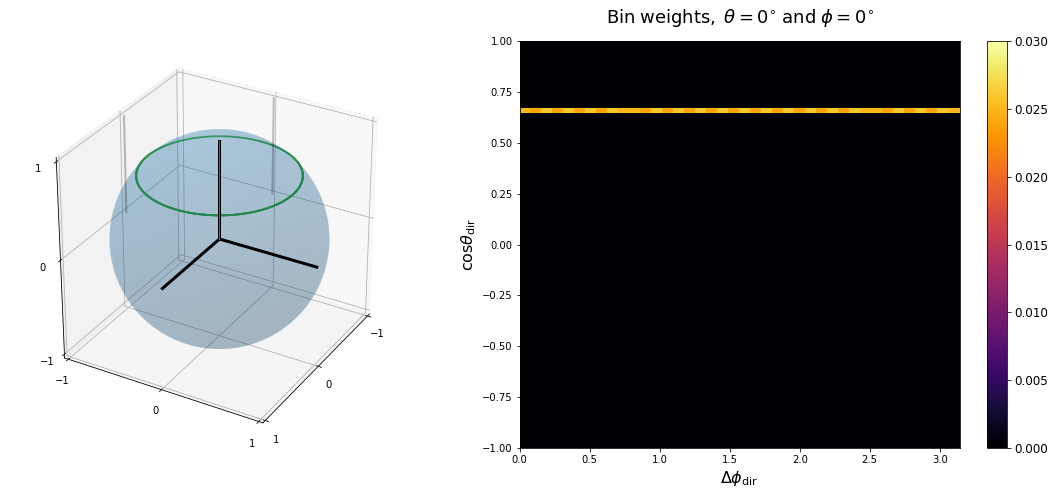

In [142]:
%%time

p_theta = cherenkov_angle
p_phi = np.linspace(0, 2*np.pi*(1 - 1/n_samp), n_samp)

thetas = np.arange(0, 180+1, 15)
phis = np.arange(0, 360, 15)

dpdir_b = OneDimBinning('deltaphidir', tex=r'\Delta\phi_{\rm dir}',
                        domain=[0, np.pi], is_lin=True, num_bins=40)
ctdir_b = OneDimBinning('costhetadir', tex=r'\cos\theta_{\rm dir}',
                        domain=[-1, 1], is_lin=True, num_bins=80)
binning = dpdir_b * ctdir_b
bin_edges = tuple(be.m for be in binning.bin_edges)

ax_x, ax_y, ax_z = np.empty(1, dtype=ftype), np.empty(1, dtype=ftype), np.empty(1, dtype=ftype)

theta0_computed = False
theta180_computed = False

for iter_num, (theta, phi) in enumerate(product(thetas, phis)):
    #if iter_num != 50:
    #    continue
    if theta == 0 and theta0_computed:
        continue
    elif theta == 180 and theta180_computed:
        continue
        
    plt.close(1)
    fig = plt.figure(num=1, figsize=(16, 7), dpi=72)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    rot_theta = np.deg2rad(theta)
    rot_phi = np.deg2rad(phi)
    
    sph2cart(np.array([1.0]), np.array([rot_theta]), np.array([rot_phi]), ax_x, ax_y, ax_z)

    q_costheta, q_phi = rotate_circle_on_sphere(p_theta, p_phi, rot_theta, rot_phi)
    q_z = q_costheta
    q_rho = np.sqrt(1 - q_z**2)
    q_x = q_rho * np.cos(q_phi)
    q_y = q_rho * np.sin(q_phi)

    fig, ax, pts, sph = plot_points_on_sph(
        q_x, q_y, q_z,
        ax_x, ax_y, ax_z, ax=ax1
    )

    hist, edges = np.histogramdd(
        (np.abs(q_phi - bin_phi), q_costheta),
        bins=bin_edges,
        normed=False
    )
    hist = hist / hist.sum()
    hist = Map(
        name='hist',
        tex=(r'{\rm Bin \; weights}, \; \theta=%.0f^{\circ} \; {\rm and} \; \phi=%.0f^{\circ}'
             % (np.rad2deg(rot_theta), np.rad2deg(rot_phi))),
        hist=hist,
        binning=binning
    )
    #print('number of nonzero bins:', np.sum(hist.hist > 0))
    hist.plot(vmax=0.03, ax=ax2, titlesize=18, xlabelsize=16, ylabelsize=16)
    fig.tight_layout()
    fig.savefig(
        join(outdir, 'theta{}_phi{}.png'.format(theta, phi)),
        dpi=120
    )
    if theta == 0:
        theta0_computed = True
    elif theta == 180:
        theta180_computed = True
    sys.stdout.write('{} '.format(iter_num))
    sys.stdout.flush()

sys.stdout.write('\n')
pass

Let's define a single function that can rotate the points, bin them, and return bin indices and weights.

In [143]:
@numba_jit
def test_idx():
    out = [(0,0)]
    counts = [1]
    for i in range(1000):
        if (0,0) not in out:
            out.append((0,0))
            counts.append(1)
            
        if (0,1) in out:
            idx = out.index((0,1))
            counts[idx] += 1

        else:
            out.append((0,1))
            counts.append(1)
            
    return out, counts

# Run once to compile the func
out, counts = test_idx()

In [144]:
%timeit out, counts = test_idx()

10000 loops, best of 3: 71 µs per loop


In [145]:
@numba_jit
def cone_weights(theta, num_phi, rot_theta, rot_phi, num_costheta_bins, num_phi_bins):
    """
    Parameters
    ----------
    theta : scalar float
        The Cherenkov angle (i.e., half the cone's opening angle)
        
    num_phi : scalar int
        Number of azimuth samples of the circle where the cone intersects the unit sphere
        
    rot_theta : scalar float
        Rotate the cone to have axis of symmetry defined by (rot_theta, rot_phi)
        
    rot_phi : scalar float
        Rotate the cone to have axis of symmetry defined by (rot_theta, rot_phi)
        
    num_costheta_bins, num_phi_bins : scalar int

    Returns
    -------
    bin_indices : list of 2-tuples
        Indices of (costheta_dir, deltaphi_dir) bins which carry non-zero weights
        
    weights : 1D numpy.ndarray

    """
    sin_rot_theta = np.sin(rot_theta)
    cos_rot_theta = np.cos(rot_theta)
    
    sin_rot_phi = np.sin(rot_phi)
    cos_rot_phi = np.cos(rot_phi)

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    costheta_bin_width = 2.0 / num_costheta_bins
    phi_bin_width = np.pi / num_phi_bins
    
    bin_indices = []
    counts = []
    counts_total = 0.0

    for idx in range(num_phi):
        p_phi = 2*np.pi * float(idx)/float(num_phi + 1)
        sin_p_phi = np.sin(p_phi)
        cos_p_phi = np.cos(p_phi)
        q_costheta = (-sin_theta * sin_rot_theta * cos_p_phi) + (cos_theta * cos_rot_theta)
        abs_q_phi = np.abs(np.arctan2(
            (sin_p_phi * sin_theta * cos_rot_phi) + (sin_theta * sin_rot_phi * cos_p_phi * cos_rot_theta) + (sin_rot_phi * sin_rot_theta * cos_theta),
            (-sin_p_phi * sin_theta * sin_rot_phi) + (sin_theta * cos_p_phi * cos_rot_phi * cos_rot_theta) + (sin_rot_theta * cos_theta * cos_rot_phi)
        ))
        costheta_bin = int((q_costheta + 1) // costheta_bin_width)
        phi_bin = int(abs_q_phi // phi_bin_width)
        coord = (costheta_bin, phi_bin)
        if coord in bin_indices:
            idx = bin_indices.index(coord)
            counts[idx] += 1.0
        else:
            bin_indices.append(coord)
            counts.append(1.0)
        counts_total += 1.0
    
    num_nonzero_bins = len(counts)
    
    weights = np.empty(num_nonzero_bins)
    for idx in range(num_nonzero_bins):
        weights[idx] = counts[idx] / counts_total

    return bin_indices, weights

# Run once to compile the function
bin_indices, weights = cone_weights(theta=cherenkov_angle, num_phi=1000, rot_theta=0.0, rot_phi=0.0, num_costheta_bins=80, num_phi_bins=40)

In [146]:
rot_theta = np.deg2rad(30)
rot_phi = np.deg2rad(45)

%timeit bin_indices, weights = cone_weights(theta=cherenkov_angle, num_phi=10000, rot_theta=rot_theta, rot_phi=rot_phi, num_costheta_bins=80, num_phi_bins=40)

100 loops, best of 3: 2.73 ms per loop


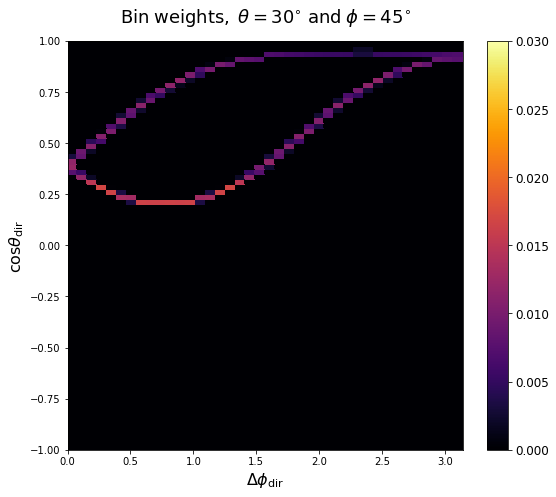

In [147]:
rot_theta = np.deg2rad(30)
rot_phi = np.deg2rad(45)
num_costheta_bins = 80
num_phi_bins = 40

bin_indices, weights = cone_weights(
    theta=cherenkov_angle,
    num_phi=10000,
    rot_theta=rot_theta,
    rot_phi=rot_phi,
    num_costheta_bins=num_costheta_bins,
    num_phi_bins=num_phi_bins
)
bin_indices = np.array(bin_indices)
hist = np.zeros((num_costheta_bins, num_phi_bins))
hist[bin_indices[:,0], bin_indices[:,1]] = weights

plt.close(1)
fig = plt.figure(num=1, figsize=(8, 7), dpi=72)
ax2 = fig.add_subplot(111)

hist = Map(
    name='hist',
    tex=(r'{\rm Bin \; weights}, \; \theta=%.0f^{\circ} \; {\rm and} \; \phi=%.0f^{\circ}'
         % (np.rad2deg(rot_theta), np.rad2deg(rot_phi))),
    hist=hist.T,
    binning=binning
)
hist.plot(vmax=0.03, ax=ax2, titlesize=18, xlabelsize=16, ylabelsize=16)
fig.tight_layout()
pass

Let's take some timings to see how long generating a mask and weights will take as a function of `n_samp`.

In [148]:
rot_theta = np.deg2rad(30)
rot_phi = np.deg2rad(30)
num_trials = 100

results = []
for num_phi in [int(1e2), int(1e3), int(1e4), int(1e5)]:
    result = dict(num_phi=num_phi)
    p_phi = np.linspace(0, 2*np.pi*(1 - 1/n_samp), n_samp)
    times = []
    for trial in range(num_trials):
        step_fract = trial / num_trials
        t0 = time()
        bin_indices, weights = cone_weights(
            theta=cherenkov_angle*step_fract,
            num_phi=num_phi,
            rot_theta=rot_theta*step_fract,
            rot_phi=rot_phi*step_fract,
            num_costheta_bins=80,
            num_phi_bins=40
        )
        t1 = time()
        times.append(t1 - t0)
    result['time_ms'] = np.round((np.mean(times)) * 1e3, 3)
    results.append(result)
    
results = pd.DataFrame(results)
results

,num_phi,time_ms
0,100,0.053
1,1000,0.404
2,10000,2.970
3,100000,23.145


Not that good, but we can revisit optimizing this later (if needed).

Okay, the last step is that we need to actually apply this to a table, so let's modify the function to directly sample from a 5D table (as produced by CLSim).

In [149]:
@numba_jit
def survival_prob_from_cone(theta, num_phi, rot_theta, rot_phi, directional_survival_prob):
    """
    Parameters
    ----------
    theta : scalar float
        Cherenkov angle (half the cone's opening angle)
        
    num_phi : scalar int
        Number of azimuth samples of the circle where the cone intersects the unit sphere
        
    rot_theta : scalar float
        Rotate the cone to have axis of symmetry defined by (rot_theta, rot_phi)
        
    rot_phi : scalar float
        Rotate the cone to have axis of symmetry defined by (rot_theta, rot_phi)
        
    directional_survival_prob : ndarray of shape (N_costhetadir x N_deltaphidir)

    Returns
    -------
    survival_prob : scalar float

    """
    num_costheta_bins, num_phi_bins = directional_survival_prob.shape
    
    sin_rot_theta = np.sin(rot_theta)
    cos_rot_theta = np.cos(rot_theta)
    
    sin_rot_phi = np.sin(rot_phi)
    cos_rot_phi = np.cos(rot_phi)

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    costheta_bin_width = 2.0 / num_costheta_bins
    deltaphi_bin_width = np.pi / num_phi_bins
    
    bin_indices = []
    counts = []
    counts_total = 0.0

    for idx in range(num_phi):
        p_phi = 2*np.pi * float(idx)/float(num_phi + 1)
        sin_p_phi = np.sin(p_phi)
        cos_p_phi = np.cos(p_phi)
        q_costheta = (-sin_theta * sin_rot_theta * cos_p_phi) + (cos_theta * cos_rot_theta)
        abs_q_phi = np.abs(np.arctan2(
            (sin_p_phi * sin_theta * cos_rot_phi) + (sin_theta * sin_rot_phi * cos_p_phi * cos_rot_theta) + (sin_rot_phi * sin_rot_theta * cos_theta),
            (-sin_p_phi * sin_theta * sin_rot_phi) + (sin_theta * cos_p_phi * cos_rot_phi * cos_rot_theta) + (sin_rot_theta * cos_theta * cos_rot_phi)
        ))
        costheta_bin = int((q_costheta + 1) // costheta_bin_width)
        deltaphi_bin = int(abs_q_phi // deltaphi_bin_width)
        coord = (costheta_bin, deltaphi_bin)
        if coord in bin_indices:
            idx = bin_indices.index(coord)
            counts[idx] += 1
        else:
            bin_indices.append(coord)
            counts.append(1)
        counts_total += 1

    num_nonzero_bins = len(counts)
    survival_prob = 0.0
    for idx, count in zip(bin_indices, counts):
        survival_prob += directional_survival_prob[idx] * count

    survival_prob /= float(counts_total)

    return survival_prob

# Run once to compile the function
survival_prob = survival_prob_from_cone(theta=cherenkov_angle, num_phi=1000, rot_theta=0.0, rot_phi=0.0, directional_survival_prob=np.ones((10, 20)))

## Test the code as it was ultimately implemented in Retro

In [152]:
ctdir_b = OneDimBinning(
    'costhetadir', tex=r'\cos\theta_{\rm dir}',
    domain=[-1, 1], is_lin=True, num_bins=80
)
dpdir_b = OneDimBinning(
    'deltaphidir', tex=r'\Delta\phi_{\rm dir}',
    domain=[0, np.pi], is_lin=True, num_bins=40
)
dir_binning = ctdir_b * dpdir_b
survival_prob = dir_binning.ones(name='survival_prob')

In [153]:
COS_CKV = 0.764540803152 ; THETA_CKV = np.arccos(COS_CKV)
rot_theta = 180-np.rad2deg(THETA_CKV) # deg
rot_phi = 180 # deg
num_phi = int(1e5)
sigma_theta = 10 # deg

common_kwargs = dict(
    num_phi=num_phi,
    rot_costheta=np.cos(np.deg2rad(rot_theta)),
    rot_sintheta=np.sin(np.deg2rad(rot_theta)),
    rot_cosphi=np.cos(np.deg2rad(rot_phi)),
    rot_sinphi=np.sin(np.deg2rad(rot_phi)),
    directional_survival_prob=survival_prob.hist,
    num_costheta_bins=ctdir_b.num_bins,
    num_deltaphi_bins=dpdir_b.num_bins,
)

First, test the "simple" code that does not smear the points on the Cherenkov cone.

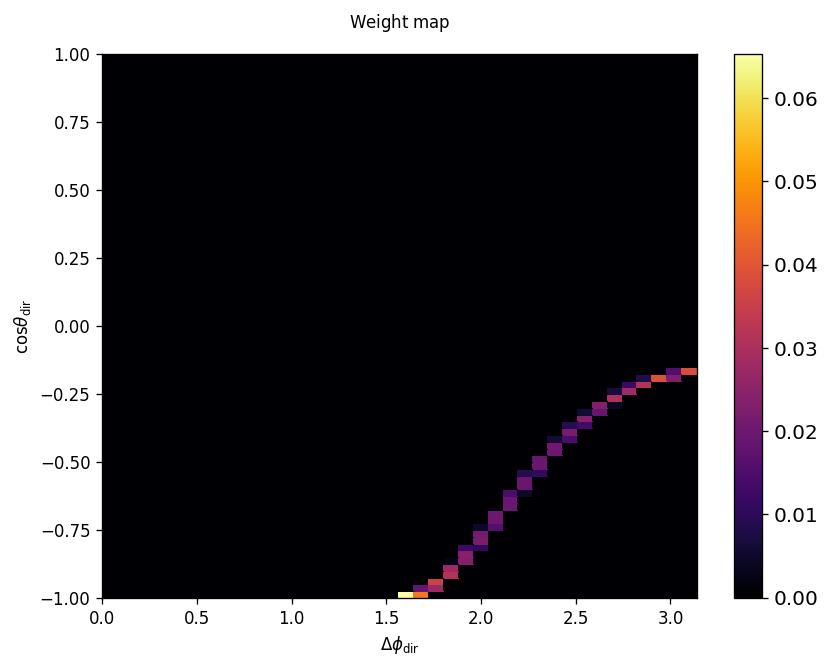

In [156]:
smsp, bin_indices, counts = survival_prob_from_cone(
    costheta=COS_CKV,
    sintheta=np.sin(THETA_CKV),
    **common_kwargs
)
total_counts = np.sum(counts)
weight_map = dir_binning.zeros(name='Weight map')
for bin_idx, count in zip(bin_indices, counts):
    weight_map.hist[bin_idx] = count / total_counts
transp = weight_map.reorder_dimensions(('deltaphidir', 'costhetadir'))
transp.plot(fig_kw=dict(figsize=(8, 6), dpi=120))
pass

Now test the code that smears out the Cherenkov cone.

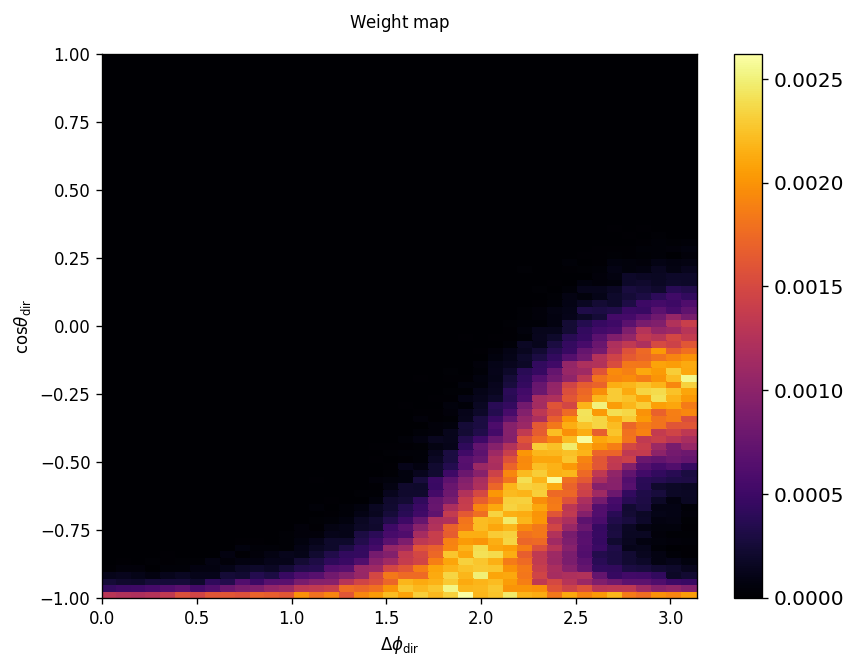

In [154]:
rand = np.random.RandomState(0)
random_delta_thetas = rand.normal(loc=0, scale=np.deg2rad(sigma_theta), size=num_phi)
smsp, bin_indices, counts = survival_prob_from_smeared_cone(
   theta=THETA_CKV,
   random_delta_thetas=random_delta_thetas,
   **common_kwargs
)
total_counts = np.sum(counts)
weight_map = dir_binning.zeros(name='Weight map')
for bin_idx, count in zip(bin_indices, counts):
    weight_map.hist[bin_idx] = count / total_counts
transp = weight_map.reorder_dimensions(('deltaphidir', 'costhetadir'))
transp.plot(fig_kw=dict(figsize=(8, 6), dpi=120))
pass